Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1314/1314 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - loss: 0.0925 - val_loss: 0.0839
Epoch 2/20
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - loss: 0.0844 - val_loss: 0.0851
Epoch 3/20
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: 0.0840 - val_loss: 0.0830
Epoch 4/20
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - loss: 0.0850 - val_loss: 0.0826
Epoch 5/20
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - loss: 0.0835 - val_loss: 0.0835
Epoch 6/20
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - loss: 0.0836 - val_loss: 0.0839
Epoch 7/20
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: 0.0834 - val_loss: 0.0836
Epoch 8/20
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 0.0828 - val_loss: 0.0833
Epoch 9/20
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.0839 - val_loss: 0.0826
Epoch 10/20
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.0838 - val_loss: 0.0832
Epoch 11/20
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - loss: 0.0839 - val_loss: 0.0833
Epoch 12/20
1314/13

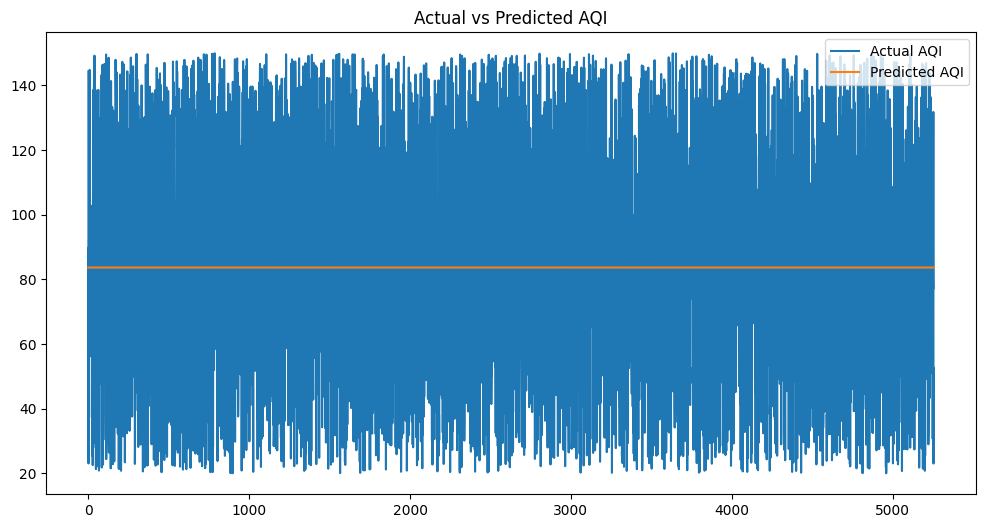

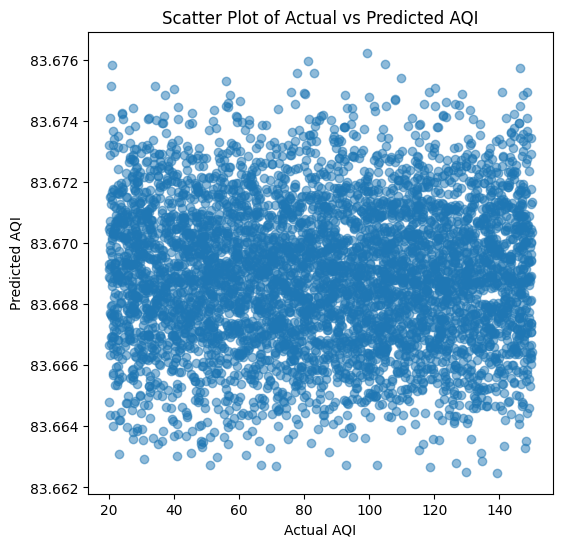

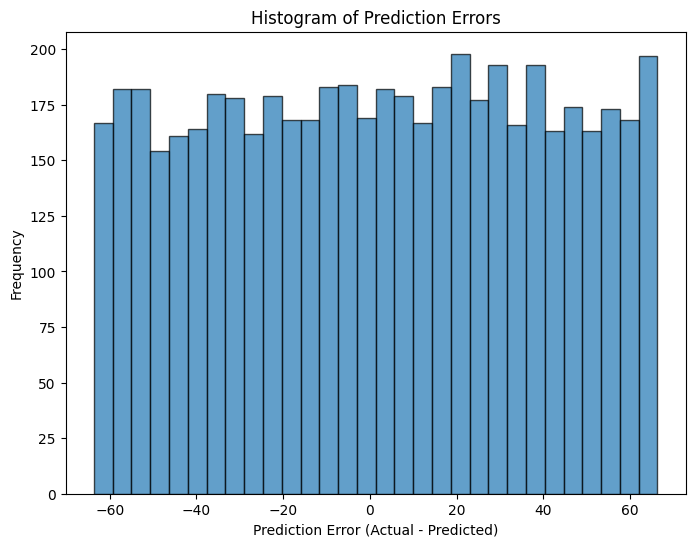

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('/content/air_quality_data (1).csv', parse_dates=['date'], index_col='date')

# Select features
features = ['PM2.5', 'PM10', 'NO2', 'CO', 'temperature', 'humidity', 'traffic']
data = data[features]

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Prepare sequences for time-series forecasting
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps, 0])  # Predicting PM2.5
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled)

# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Define LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Predict and visualize
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(
    np.concatenate((predictions, np.zeros((len(predictions), data.shape[1]-1))), axis=1)
)[:, 0]

y_test_actual = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), data.shape[1]-1))), axis=1)
)[:, 0]

# Line plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual AQI')
plt.plot(predictions, label='Predicted AQI')
plt.legend()
plt.title("Actual vs Predicted AQI")
plt.show()

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test_actual, predictions, alpha=0.5)
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Scatter Plot of Actual vs Predicted AQI")
plt.show()

# Histogram
plt.figure(figsize=(8, 6))
plt.hist(y_test_actual - predictions, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Histogram of Prediction Errors")
plt.show()
